# SensRay Moon model/mesh generation with computation of travel times from sensitivity kernels

This notebook demonstrates the generation of a moon model :
- Creating Moon models (M1, M2, M3, weber_core_smooth, weber_core)
- Creating tetrahedral meshes using model discontinuities and parameters
- Populating seismic properties
- Basic visualization and cross-sections
- Sources, receivers, and phases with rays computed
- Computation and visualization of sensitivity kernels and ray paths
- Sparse G matrix calculation
- Delta V scalar field generation, projection, and visualisation
- Computation of travel times using dv with G

In [1]:
import numpy as np
from itertools import product
from sensray import PlanetModel, CoordinateConverter
from fwdop import GFwdOp, make_scalar_field
import matplotlib.pyplot as plt

## 1. Creation of Moon model and mesh

Creating a model and mesh for ray tracing

### Creating model

Creating a moon model from information stored in .nd file
- User-defined model (model_name), mesh size, and inner core mesh size
- Model creation of PlanetModel class

In [2]:
# User-defined parameters
model_name = "M1"
mesh_size_km = 1000
mesh_size_inner_km = 600

# Model creation
model = PlanetModel.from_standard_model(model_name)

### Creating layered tetrahedral mesh

Uses a layered tetrahedral mesh to control resolution across discontinuities
- User-defined mesh name
- Radii and H_layers gathered from the model properties
- Populate mesh properties with vp, vs, rho from the file (also gathered from model)

In [3]:
# Create mesh and save if not exist, otherwise load existing
mesh_name = "M1_mesh"

try:
    model.create_mesh(from_file=mesh_name)
    print(f"Loaded existing mesh from {mesh_name}")
except FileNotFoundError:
    print("Creating new mesh...")
    radii = model.get_discontinuities()
    H_layers = [mesh_size_km]*(len(radii)-1)+[mesh_size_inner_km]
    model.create_mesh(mesh_size_km=mesh_size_km, radii=radii, H_layers=H_layers)
    model.mesh.populate_properties(model.get_info()["properties"])
    model.mesh.save(f"{model_name}_mesh")  # Save mesh to VT
print(f"Created mesh: {model.mesh.mesh.n_cells} cells")

Loaded mesh from M1_mesh.vtu
Loaded metadata: 9975 cells, 2258 points
Loaded existing mesh from M1_mesh
Created mesh: 9975 cells


Visualisation of 1D Vp, Vs, Rho profiles in the model

Plot 1D Vp, Vs, Rho profiles...


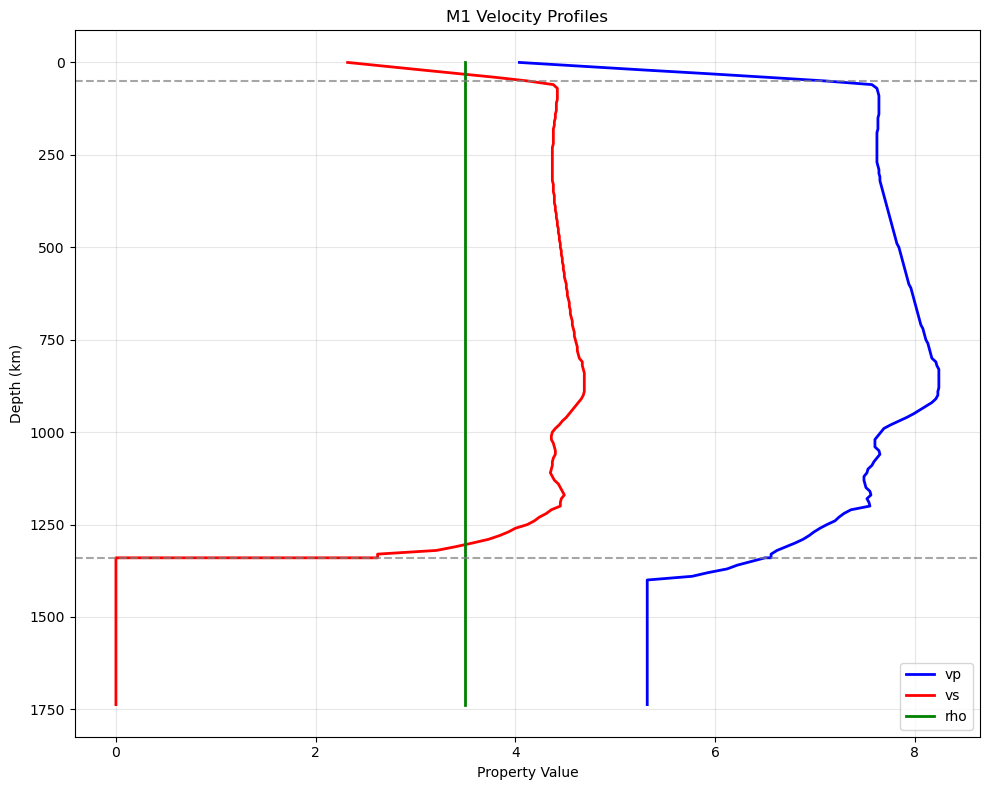

In [4]:
# Plot 1D velocity profiles
print("Plot 1D Vp, Vs, Rho profiles...")
fig, ax = model.plot_profiles(max_depth_km=model.radius)
plt.title('M1 Velocity Profiles')
plt.show()

Visualisation of Vp and Vs variations in the model

In [ ]:
# Cross-section through the equator (y=0 plane)
print("Vp visualisation (y-0 plane)...")
plotter = model.mesh.plot_cross_section(
    plane_normal=(0, 1, 0),  # y=0 plane
    property_name='vp',
    show_edges=True
)
plotter.camera.position = (10000, 8000, 8000)
plotter.show()

# Cross-section through the equator (y=0 plane)
print("Vs visualisation (y-0 plane)...")
plotter = model.mesh.plot_cross_section(
    plane_normal=(0, 1, 0),  # y=0 plane
    property_name='vs',
    show_edges=True
)
plotter.camera.position = (10000, 8000, 8000)
plotter.show()

Vp visualisation (y-0 plane)...


Widget(value='<iframe src="http://localhost:42727/index.html?ui=P_0x7fe393f4a450_0&reconnect=auto" class="pyvi…

Vs visualisation (y-0 plane)...


Widget(value='<iframe src="http://localhost:42727/index.html?ui=P_0x7fe393f49250_1&reconnect=auto" class="pyvi…

Exception raised
KeyError('6c57a890a65836ba5b7817292322aefb_2175f')
Traceback (most recent call last):
  File "/home/matth/miniconda3/envs/masters-project/lib/python3.11/site-packages/wslink/protocol.py", line 324, in onCompleteMessage
    results = func(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^
  File "/home/matth/miniconda3/envs/masters-project/lib/python3.11/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/home/matth/miniconda3/envs/masters-project/lib/python3.11/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 41, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
                ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
KeyError: '6c57a890a65836ba5b7817292322aefb_2175f'



## 2. Define Source-Receiver Geometry

Set up realistic earthquake-station-phase and translate to earthquake-station-ray combination(s).

In practise this will be created and filtered individually by the user, then passed into the forward operator. 

### Point generation

Function to generate a point in the model with optional parameters for min/max point type, latitude, longitde, and depth. Alternatively using predefined single source-receiver-phase

In [6]:
# function to make points
def point(pointType="Source", minLat=-90, maxLat=90, minLon=-180, maxLon=180, minDepth=0, maxDepth=700):
    '''
    pointType: "Source" or "Receiver"
    For Source: lat, lon, depth
    For Receiver: lat, lon
    returns: (lat, lon, depth) or (lat, lon)
    '''
    if pointType == "Source":
        lat = np.random.uniform(minLat, maxLat)
        lon = np.random.uniform(minLon, maxLon)
        depth = np.random.uniform(minDepth, maxDepth)  # depth in km
        return (lat, lon, depth)
    elif pointType == "Receiver":
        lat = np.random.uniform(minLat, maxLat)
        lon = np.random.uniform(minLon, maxLon)
        return (lat, lon)
    else:
        raise ValueError("pointType must be 'Source' or 'Receiver'")


print("Source-receiver-phase list generation...")
# Generate source and receiver points and combinations
# sources = [point("Source", minDepth=150, maxDepth=150) for _ in range(2)]
# receivers = [point("Receiver", maxDepth=0) for _ in range(5)]
# phases = ["P", "S", "ScS"]
# srp = [prod + tuple([phases]) for prod in product(sources, receivers)]

# testing with one source-receiver pair - same as initial test
source_lat, source_lon, source_depth = 0.0, 0.0, 150.0  # Equator, 150 km depth
receiver_lat, receiver_lon = 30.0, 45.0  # Surface station
srp = [((source_lat, source_lon, source_depth), (receiver_lat, receiver_lon), ["P", "S", "ScS"])]

Source-receiver-phase list generation...


### Ray tracing with taup

Function to generate a ray using taup for each phase of interest for each source-receiver pair. Save as a list of lists of [source-receiver-ray] to be passed into the forward operatot

In [7]:
def get_rays(srp):
    '''
    srp: list of tuples (source, receiver, phases)
    where source = (lat, lon, depth), receiver = (lat, lon), phases = [phase1, phase2, ...]
    returns array of (source, receiver, ray) for each ray
    '''
    srr_list = []
    for (source, receiver, phases) in srp:
        rays = model.taupy_model.get_ray_paths_geo(
            source_depth_in_km=source[2],
            source_latitude_in_deg=source[0],
            source_longitude_in_deg=source[1],
            receiver_latitude_in_deg=receiver[0],
            receiver_longitude_in_deg=receiver[1],
            phase_list=phases,
        )
        for ray in rays:
            srr_list.append((source, receiver, ray))

    return np.array(srr_list, dtype=object)


print("Compute ray for each source-receiver-phase combination...")
srr = get_rays(srp)

Compute ray for each source-receiver-phase combination...
Building obspy.taup model for '/home/matth/Masters-Project/SensRay/sensray/models/M1.nd' ...
filename = /home/matth/Masters-Project/SensRay/sensray/models/M1.nd
Done reading velocity model.
Radius of model . is 1737.1
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  643 P layers,747 S layers
Done calculating Tau branches.
Done Saving /tmp/M1.npz
Method run is done, but not necessarily successful.


## 3. Compute sensitivity kernels and G matrix

Compute travel-time sensitivity kernels: K = -L / v² for each ray using GFwdOp(LinearOperator) and store as a sparse G matrix

In [8]:
print("Calculate sensitivity kernels and sparse G matrix...")
G = GFwdOp(model, srr[:,2])

Calculate sensitivity kernels and sparse G matrix...
Stored sensitivity kernel as cell data: 'K_P_vp'
Stored sensitivity kernel as cell data: 'K_S_vs'
Stored sensitivity kernel as cell data: 'K_ScS_vs'
Stored sensitivity kernel as cell data: 'K_S_vs'
Stored sensitivity kernel as cell data: 'K_ScS_vs'
P Kernel Matrix shape: (1, 9975), nnz: 24
S Kernel Matrix shape: (2, 9975), nnz: 59
ScS Kernel Matrix shape: (2, 9975), nnz: 122


# 4. Create Dv and apply to G

Create vectorized scalar field from radial and angular functions R(r), T(θ,φ) then project onto the mesh. Apply Dv to G to compute travel times.

### Scalar field generation

Import function to convert radial and angular functions to a vectorized scalar function in f(x,y,z)

In [ ]:
print(f"Scalar field generation...")
# make function for velocity perturbation
# Define R(r) and T(theta, phi)
# R = lambda r: r**2 * np.exp(-r/100000)
# T = lambda theta, phi: np.cos(theta)

R = lambda r: np.ones_like(r)
T = lambda theta, phi: np.ones_like(theta)

f = make_scalar_field(R, T)

Scalar function generation...


### Dv mesh projection and visualisation

Project scalar field onto the mesh to calculate dv

In [10]:
print("Dv projection onto mesh...")
model.mesh.project_function_on_mesh(f, property_name="dv")

Dv projection onto mesh...


Visualise dv field using wrapper in mesh and first source-receiver pair for calculation of plane for slice

In [ ]:
print("Dv visualization...")
model.mesh.display_dv(srr[0,0][0], srr[0,0][1], srr[0,1][0], srr[0,1][1], property_name="dv")

Dv visualization...
Background P-wave velocity:


Widget(value='<iframe src="http://localhost:42727/index.html?ui=P_0x7fe37c0d25d0_2&reconnect=auto" class="pyvi…

### Time travel computation

Apply dv to G forward operator to compute travel times.

In [12]:
print("Time travel computation...")
travel_times = G(model.mesh.mesh.cell_data["dv"])
print(travel_times)

Time travel computation...
[ -24.09199656  -72.78845671 -135.30133456 -322.22473719 -291.89129329]
